In [1]:
import sys

sys.path.append("..")

import tensorflow as tf

import tensorflow_probability as tfp

import numpy as np

import GPyOpt

import argparse

from utils import tf_config, preprocess_data, search_algorithms, train, bnn_utils, outlier_utils

from models import fmri_ae, eeg_to_fmri, uniconv_fmri, bnn_fmri_ae

from layers import locally_connected

import matplotlib.pyplot as plt

import gc

import os

from sklearn.model_selection import train_test_split, KFold

import time

dataset="01"
memory_limit=4000
n_individuals=8
interval_eeg=6

tf_config.set_seed(seed=42)
tf_config.setup_tensorflow(device="GPU", memory_limit=memory_limit)

with tf.device('/CPU:0'):
    train_data, val_data = preprocess_data.dataset(dataset, n_individuals=n_individuals, 
                                            interval_eeg=interval_eeg, 
                                            ind_volume_fit=True,
                                            standardize_fmri=True,
                                            iqr=False,
                                            verbose=True)
    _, train_x=train_data
    _, val_x=val_data
    
    train_x = train_x.astype('float32')
    val_x = val_x.astype('float32')

I: Starting to Load Data
I: Finished Loading Data
I: Pairs Created


## Remove outlier values

In [2]:
iqr = outlier_utils.IQR()
iqr.fit(train_x)
train_x = iqr.transform(train_x, channels_last=False)

In [3]:
batch_size=16
learning_rate=0.0001
skip_connections=True
maxpool=True
batch_norm=True
n_channels=4
latent_dimension=(5,5,5)
kernel_size=(9,9,4)
stride_size=(1,1,1)
n_stacks=3

optimizer = tf.keras.optimizers.Adam(learning_rate)

train_set = tf.data.Dataset.from_tensor_slices((train_x, train_x)).batch(batch_size)
dev_set = tf.data.Dataset.from_tensor_slices((val_x, val_x)).batch(1)

## Start playing with uncertainty

In [4]:
from models import bnn_fmri_ae

import importlib
importlib.reload(bnn_fmri_ae)

def create_bayesian_model(input_shape, output_shape, latent_shape, kernel_size, stride_size, n_channels,
                        maxpool=True, batch_norm=True, weight_decay=0.000, skip_connections=False,
                        n_stacks=2, local=True, local_attention=False, outfilter=0):
    
    model = bnn_fmri_ae.BNN_fMRI_AE(latent_shape, output_shape, 
                    kernel_size, stride_size, n_channels,
                    maxpool=maxpool, batch_norm=batch_norm,
                    skip_connections=skip_connections, n_stacks=n_stacks, 
                    local=True, local_attention=False, outfilter=0)
    
    
    
    model.build(input_shape=(None,)+input_shape)
    
    return model


model = create_bayesian_model(train_x.shape[1:], train_x.shape[1:], latent_dimension,
                    kernel_size, stride_size, n_channels,
                    maxpool=maxpool, batch_norm=batch_norm,
                    skip_connections=skip_connections, n_stacks=n_stacks, 
                    local=True, local_attention=False, outfilter=0)

In [5]:
model.summary()

Model: "bnn_f_mri_ae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           [(None, 64, 64, 30, 1), ( 31144559  
Total params: 31,144,559
Trainable params: 31,144,479
Non-trainable params: 80
_________________________________________________________________


In [8]:
start_time = time.time()

#train
train_loss, val_loss = train.train(train_set, model, optimizer, 
                                   bnn_utils.combined_log_abs_loss, epochs=2, 
                                   val_set=dev_set, verbose=True)

print("Time training: ", time.time()-start_time)

Epoch 1 with loss: 29.48998227849737
Epoch 2 with loss: 24.675003739090652
Time training:  1406.309112071991


# Compute aleatoric uncertainty and epistemic uncertainty

#### Plot Ground truth, Predicted, Aleatoric Uncertainty and Epistemic Uncertainty

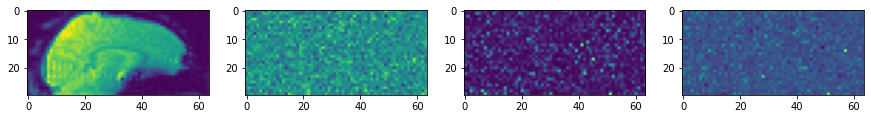

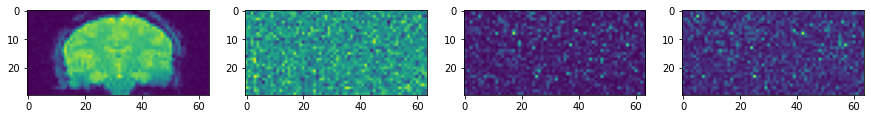

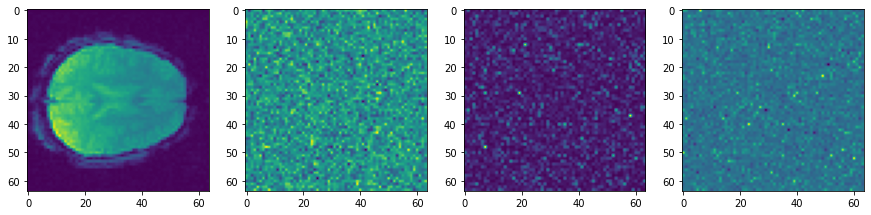

In [9]:
from scipy.ndimage import rotate

volume=50
xslice=30
yslice=30
zslice=15
array_set=val_x

fig, axes = plt.subplots(1, 4, figsize=(15,30))
axes[0].imshow(rotate(array_set[volume,xslice,:,:,:], 90))
axes[1].imshow(rotate(model(array_set[volume:volume+1])[0].numpy()[0,xslice,:,:,:], 90, axes=(0,1)))
axes[2].imshow(rotate(bnn_utils.aleatoric_uncertainty(model, array_set[volume:volume+1]).numpy()[0,xslice,:,:,:], 90, axes=(0,1)))
axes[3].imshow(rotate(bnn_utils.epistemic_uncertainty(model, array_set[volume:volume+1]).numpy()[0,xslice,:,:,:], 90, axes=(0,1)))
plt.show()


fig, axes = plt.subplots(1, 4, figsize=(15,30))
axes[0].imshow(rotate(array_set[volume,:,yslice,:,:], 90))
axes[1].imshow(rotate(model(array_set[volume:volume+1])[0].numpy()[0,:,yslice,:,:], 90, axes=(0,1)))
axes[2].imshow(rotate(bnn_utils.aleatoric_uncertainty(model, array_set[volume:volume+1]).numpy()[0,:,yslice,:,:], 90, axes=(0,1)))
axes[3].imshow(rotate(bnn_utils.epistemic_uncertainty(model, array_set[volume:volume+1]).numpy()[0,:,yslice,:,:], 90, axes=(0,1)))
plt.show()


fig, axes = plt.subplots(1, 4, figsize=(15,30))
axes[0].imshow(array_set[volume,:,:,zslice,:])
axes[1].imshow(model(array_set[volume:volume+1])[0].numpy()[0,:,:,zslice,:])
axes[2].imshow(bnn_utils.aleatoric_uncertainty(model, array_set[volume:volume+1]).numpy()[0,:,:,zslice,:])
axes[3].imshow(bnn_utils.epistemic_uncertainty(model, array_set[volume:volume+1]).numpy()[0,:,:,zslice,:])
plt.show()